In [11]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
text_tokenizer = AutoTokenizer.from_pretrained(
    "/home/chengzhang/models/llama-hf/llama-7b_hf",
    local_files_only=False,
    trust_remote_code=True,
)
# add Flamingo special tokens to the tokenizer
text_tokenizer.add_special_tokens(
    {"additional_special_tokens": ["<|endofchunk|>", "<image>"]}
)
if text_tokenizer.pad_token is None:
    # Issue: GPT models don't have a pad token, which we use to
    # modify labels for the loss.
    text_tokenizer.add_special_tokens({"pad_token": "<PAD>"})

lang_encoder = AutoModelForCausalLM.from_pretrained(
    "/home/chengzhang/models/llama-hf/llama-7b_hf",
    local_files_only=False,
    trust_remote_code=True,
)

Using pad_token, but it is not set yet.


[2023-11-03 02:13:56,282] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


In [3]:
lang_encoder = lang_encoder.cuda()

In [5]:
linear_modules: dict[str, torch.nn.Module] = {}

for i, layer in enumerate(lang_encoder.model.layers):
    for x in ['q', 'o']:  # ['q', 'k', 'v', 'o']:
        proj_id = f'llama/{i}-self-{x}-proj'
        linear_modules[proj_id] = getattr(layer.self_attn, f'{x}_proj')
    for x in ['down', 'up']:  # ['gate', 'down', 'up']:
        proj_id = f'llama/{i}-self-{x}-proj'
        linear_modules[proj_id] = getattr(layer.mlp, f'{x}_proj')

for name, module in linear_modules.items():
    module.unique_name = name

ln_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(lang_encoder.model.layers):
    ln_modules[f'llama/{i}-self-input-ln'] = layer.input_layernorm
    ln_modules[f'llama/{i}-self-post-attn-ln'] = layer.post_attention_layernorm

for name, module in ln_modules.items():
    module.unique_name = name

In [12]:
with open('/home/chengzhang/datasets/OK-VQA/question/OpenEnded_mscoco_val2014_questions.json') as f:
    questions = json.loads(f.read())['questions']

hooks = []

SNAPSHOT_PATH = '/home/chengzhang/Multimodal-Quantization/open_flamingo/snapshot'

In [9]:
def save_activations(hooks):

    for i in range(20):

        q = questions[i]
        question = q['question']
        question_id = q['question_id']
        text = f'Question: {question} answer:'

        lang_x = text_tokenizer([question], return_tensors="pt")

        act_folder = f'{SNAPSHOT_PATH}/activations-text-gen/{question_id}'
        os.makedirs(f'{act_folder}/vit', exist_ok=True)
        os.makedirs(f'{act_folder}/perceiver', exist_ok=True)
        os.makedirs(f'{act_folder}/llama', exist_ok=True)

        for hook in hooks:
            hook.remove()
        hooks = []

        cache = {}

        def hook(m, input, output):
            # torch.save(input, f'{act_folder}/{m.unique_name}.pt')
            if input[0].shape[1] == 1:
                if m.unique_name in cache:
                    cache[m.unique_name] = torch.concat((cache[m.unique_name], input[0]), 1)
                else:
                    cache[m.unique_name] = input[0]

        for name, module in linear_modules.items():
            hooks.append(module.register_forward_hook(hook))

        print(f'\n ########## [{i}] {question_id} ##########')

        # lang_encoder(lang_x["input_ids"].cuda(), lang_x["attention_mask"].cuda())

        lang_encoder.generate(
            lang_x["input_ids"].cuda(),
            do_sample=False,
            max_new_tokens=50,
            use_cache=True,
        )

        for name, val in cache.items():
            # print(name, val.shape)
            torch.save((val, ), f'{act_folder}/{name}.pt')

# save_activations(hooks)


 ########## [0] 2971475 ##########



 ########## [1] 3397615 ##########

 ########## [2] 3575865 ##########

 ########## [3] 949225 ##########

 ########## [4] 2076115 ##########

 ########## [5] 5723996 ##########

 ########## [6] 5759705 ##########

 ########## [7] 3045575 ##########

 ########## [8] 2183655 ##########

 ########## [9] 2863135 ##########

 ########## [10] 299845 ##########

 ########## [11] 115115 ##########

 ########## [12] 3234605 ##########

 ########## [13] 5169165 ##########

 ########## [14] 217115 ##########

 ########## [15] 3133865 ##########

 ########## [16] 4026395 ##########

 ########## [17] 4575845 ##########

 ########## [18] 4883775 ##########

 ########## [19] 3017535 ##########


In [13]:
def load_act(
    path: str,
    comp: str,
    seq_start: int = 0,
    seq_end: int = 10,
    token_start: int = None,
    token_end: int = None
) -> np.ndarray:
    acts = []
    tokens = 0
    for i in range(seq_start, seq_end):
        question_id = questions[i]['question_id']
        act_folder = f'{path}/{question_id}'
        act: torch.Tensor = torch.load(f'{act_folder}/llama/{comp}.pt')[0][0]
        if token_end is not None:
            act = act[:token_end]
        if token_start is not None:
            act = act[token_start:]
        if act.shape[0] > 0:
            acts.append(act.abs().max(dim=0).values.detach())
        # acts.append(act.abs().sum(dim=0).detach())
        tokens += act.shape[0]
    return torch.stack(acts).max(dim=0).values.cpu().numpy()
    # return (torch.stack(acts).sum(dim=0) / tokens).cpu().numpy()

In [5]:
def plot_layer_2(left: np.ndarray, right: np.ndarray, titles: list[str]):
    channels = left.shape[-1]
    outliers = channels // 100

    left_outliers = left.argsort()[-outliers:]
    right_outliers = right.argsort()[-outliers:]
    left_spec_outliers = set(left_outliers) - set(right_outliers)
    right_spec_outliers = set(right_outliers) - set(left_outliers)
    print(len(left_spec_outliers))

    left_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    right_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    for idx in left_outliers:
        left_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in right_outliers:
        right_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in left_spec_outliers:
        left_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    for idx in right_spec_outliers:
        right_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    
    max_val = max(left.max(), right.max())

    print(left.argmax(), left.max())
    print(right.argmax(), right.max())

    groups = (channels + 512 - 1) // 512

    plt.figure(figsize=(15, 2 * groups))

    def plot_group(tensor, colors, start, stop, idx, title=None):
        ax = plt.subplot(groups, 2, idx)
        ax.bar(np.arange(start, stop), tensor[start:stop], width=np.ones(stop - start), color=colors[start:stop])
        # ax.set_ylim(0, np.ceil(max_val))
        # ax.set_ylim(0, max_val)
        ax.set_ylim(0, 0.2)
        ax.set_xlim(start, start + 512)
        ax.set_xticks(np.arange(start, start + 513, 64))
        if title is not None:
            ax.set_title(title)

    for group_id in range(groups):
        start = group_id * 512
        stop = min(start + 512, channels)
        plot_group(left, left_colors, start, stop, group_id * 2 + 1, titles[1] if group_id == 0 else None)
        plot_group(right, right_colors, start, stop, group_id * 2 + 2, titles[2] if group_id == 0 else None)

    plt.suptitle(titles[0])

In [6]:
def plot_layer_3(left: np.ndarray, mid: np.ndarray, right: np.ndarray, titles: list[str]):
    channels = left.shape[-1]
    outliers = channels // 100

    left_outliers = left.argsort()[-outliers:]
    mid_outliers = mid.argsort()[-outliers:]
    right_outliers = right.argsort()[-outliers:]
    common_outliers = set(left_outliers) & set(mid_outliers) & set(right_outliers)
    left_spec_outliers = set(left_outliers) - common_outliers
    mid_spec_outliers = set(mid_outliers) - common_outliers
    right_spec_outliers = set(right_outliers) - common_outliers
    print(len(mid_spec_outliers))

    left_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    mid_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    right_colors = np.tile(np.array([0x1f, 0x77, 0xb4]) / 255, (channels, 1))
    for idx in left_outliers:
        left_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in mid_outliers:
        mid_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in right_outliers:
        right_colors[idx] = np.array([0x2c, 0xa0, 0x2c]) / 255
    for idx in left_spec_outliers:
        left_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    for idx in mid_spec_outliers:
        mid_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    for idx in right_spec_outliers:
        right_colors[idx] = np.array([0xd6, 0x27, 0x28]) / 255
    
    max_val = max(left.max(), mid.max(), right.max())

    print(left.argmax(), left.max())
    print(mid.argmax(), mid.max())
    print(right.argmax(), right.max())

    groups = (channels + 512 - 1) // 512

    plt.figure(figsize=(22, 2 * groups))

    def plot_group(tensor, colors, start, stop, idx, title=None):
        ax = plt.subplot(groups, 3, idx)
        ax.bar(np.arange(start, stop), tensor[start:stop], width=np.ones(stop - start), color=colors[start:stop])
        # ax.set_ylim(0, max_val)
        ax.set_ylim(0, 0.2)
        # ax.set_xlim(start, start + 512)
        ax.set_xticks(np.arange(start, start + 513, 64))
        if title is not None:
            ax.set_title(title)

    for group_id in range(groups):
        start = group_id * 512
        stop = min(start + 512, channels)
        plot_group(left, left_colors, start, stop, group_id * 3 + 1, titles[1] if group_id == 0 else None)
        plot_group(mid, mid_colors, start, stop, group_id * 3 + 2, titles[2] if group_id == 0 else None)
        plot_group(right, right_colors, start, stop, group_id * 3 + 3, titles[3] if group_id == 0 else None)

    plt.suptitle(titles[0])

In [14]:
def load_channel(
    path: str,
    comp: str,
    channel: int,
    seq_start: int = 0,
    seq_end: int = 20,
    token_start: int = None,
    token_end: int = None
) -> np.ndarray:
    acts = []
    tokens = 0
    for i in range(seq_start, seq_end):
        question_id = questions[i]['question_id']
        act_folder = f'{path}/{question_id}'
        act: torch.Tensor = torch.load(f'{act_folder}/llama/{comp}.pt')[0][0]
        act = act[:, channel]
        if token_end is not None:
            act = act[:token_end]
        if token_start is not None:
            act = act[token_start:]
        acts.append(act)
        tokens += act.shape[0]
    return torch.concat(acts)


bits = 4
bins = 2 ** (bits - 1)
ticks = np.square(np.arange(-1, 1, 1 / bins))
ticks[:bins] *= -1
ticks = ticks[1:]


def plot_channel(ax: plt.Axes, x: np.ndarray, plot_ticks: bool = False):
    scale = np.abs(x).max()
    thres = scale * 0.99
    quant_x = np.where(np.abs(x) < thres, x, 0.0)
    quant_scale = np.abs(quant_x).max()
    freqs, _, _ = ax.hist(x, bins=200)
    if plot_ticks:
        for pos in ticks:
            ax.plot([pos * quant_scale, pos * quant_scale], [0, max(freqs)], color='C1', linewidth=1)

In [14]:
def plot_all_comp(layer, channel, gen=False):
    plt.figure(figsize=(10, 16))

    for i, comp in enumerate(['self-q-proj', 'self-o-proj', 'self-up-proj', 'self-down-proj']):
        if gen:
            title_type = 'Gen'
            path_suffix = '-gen'
        else:
            title_type = 'Prompt'
            path_suffix = ''
        title = f'[L{layer}.{comp}] Text ({title_type})'
        ax = plt.subplot(4, 2, i * 2 + 1)
        x = load_channel(f'{SNAPSHOT_PATH}/activations-text{path_suffix}', f'{layer}-{comp}', channel).detach().cpu().numpy()
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)
        title = f'[L{layer}.{comp}] Multimodal ({title_type})'
        ax = plt.subplot(4, 2, i * 2 + 2)
        x = load_channel(f'{SNAPSHOT_PATH}/activations{path_suffix}', f'{layer}-{comp}', channel).detach().cpu().numpy()
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)

    plt.savefig(f'./snapshot/img/activations-per-channel/{layer}.{channel}{path_suffix}.png')

[L31.self-q-proj] Text (Prompt)
[L31.self-q-proj] Multimodal (Prompt)
[L31.self-o-proj] Text (Prompt)
[L31.self-o-proj] Multimodal (Prompt)
[L31.self-up-proj] Text (Prompt)
[L31.self-up-proj] Multimodal (Prompt)
[L31.self-down-proj] Text (Prompt)
[L31.self-down-proj] Multimodal (Prompt)


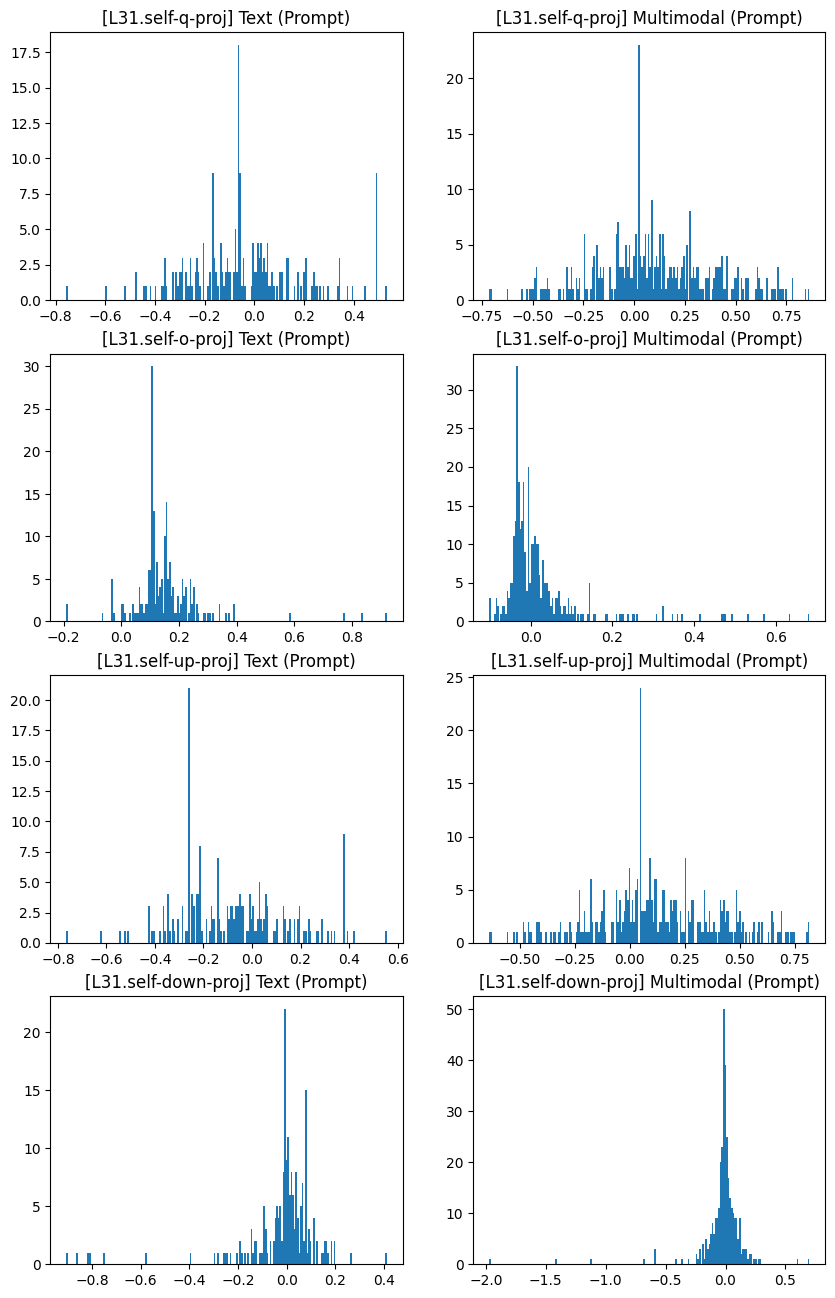

In [19]:
layer=31
plot_all_comp(layer, channel=31)

[L31.self-q-proj] Text (Gen)
[L31.self-q-proj] Multimodal (Gen)
[L31.self-o-proj] Text (Gen)
[L31.self-o-proj] Multimodal (Gen)
[L31.self-up-proj] Text (Gen)
[L31.self-up-proj] Multimodal (Gen)
[L31.self-down-proj] Text (Gen)
[L31.self-down-proj] Multimodal (Gen)


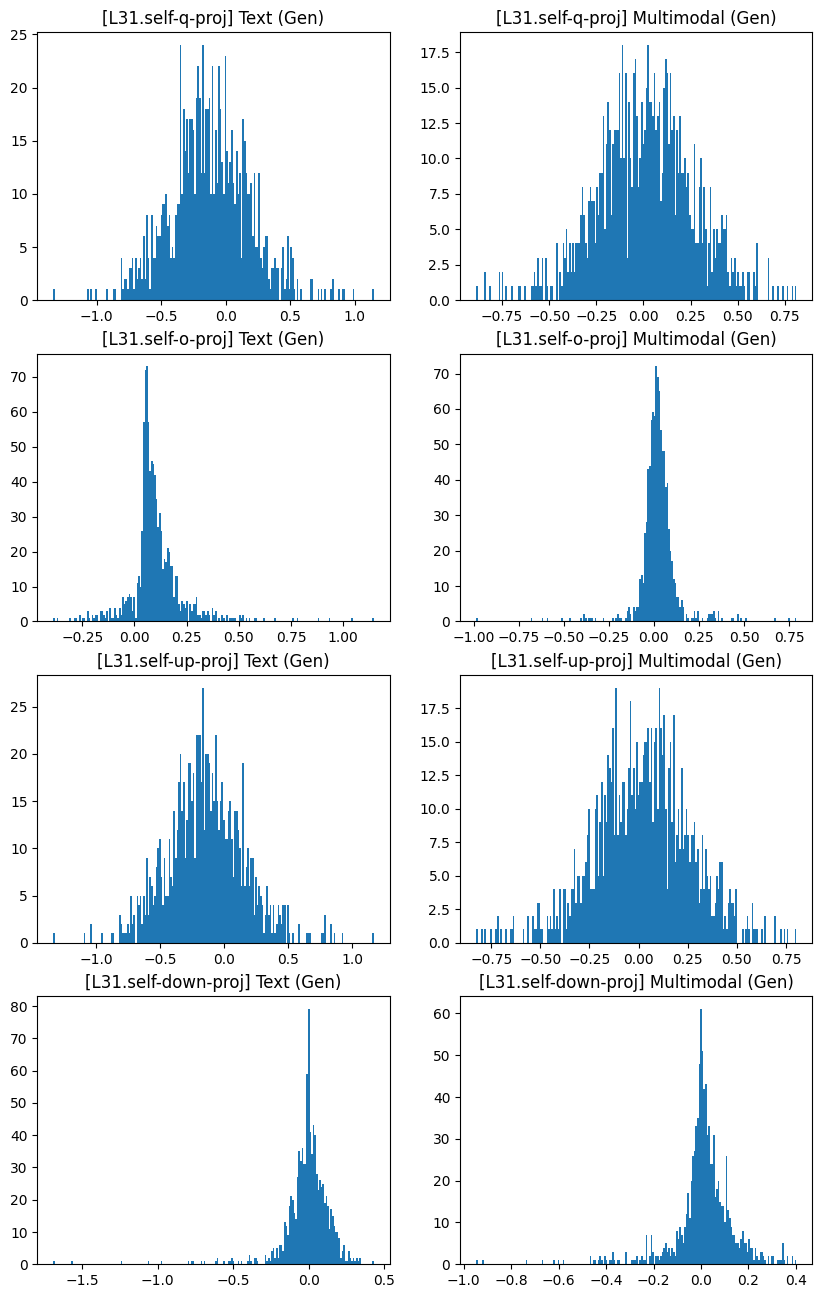

In [18]:
layer=31
plot_all_comp(layer, channel=31, gen=True)

User: ... (Prompt Prefill)
GPT: ... (Gen)
User: ... (Prompt Prefill)
GPT: ... (Gen)

17
2483 3.252
2483 3.2540047


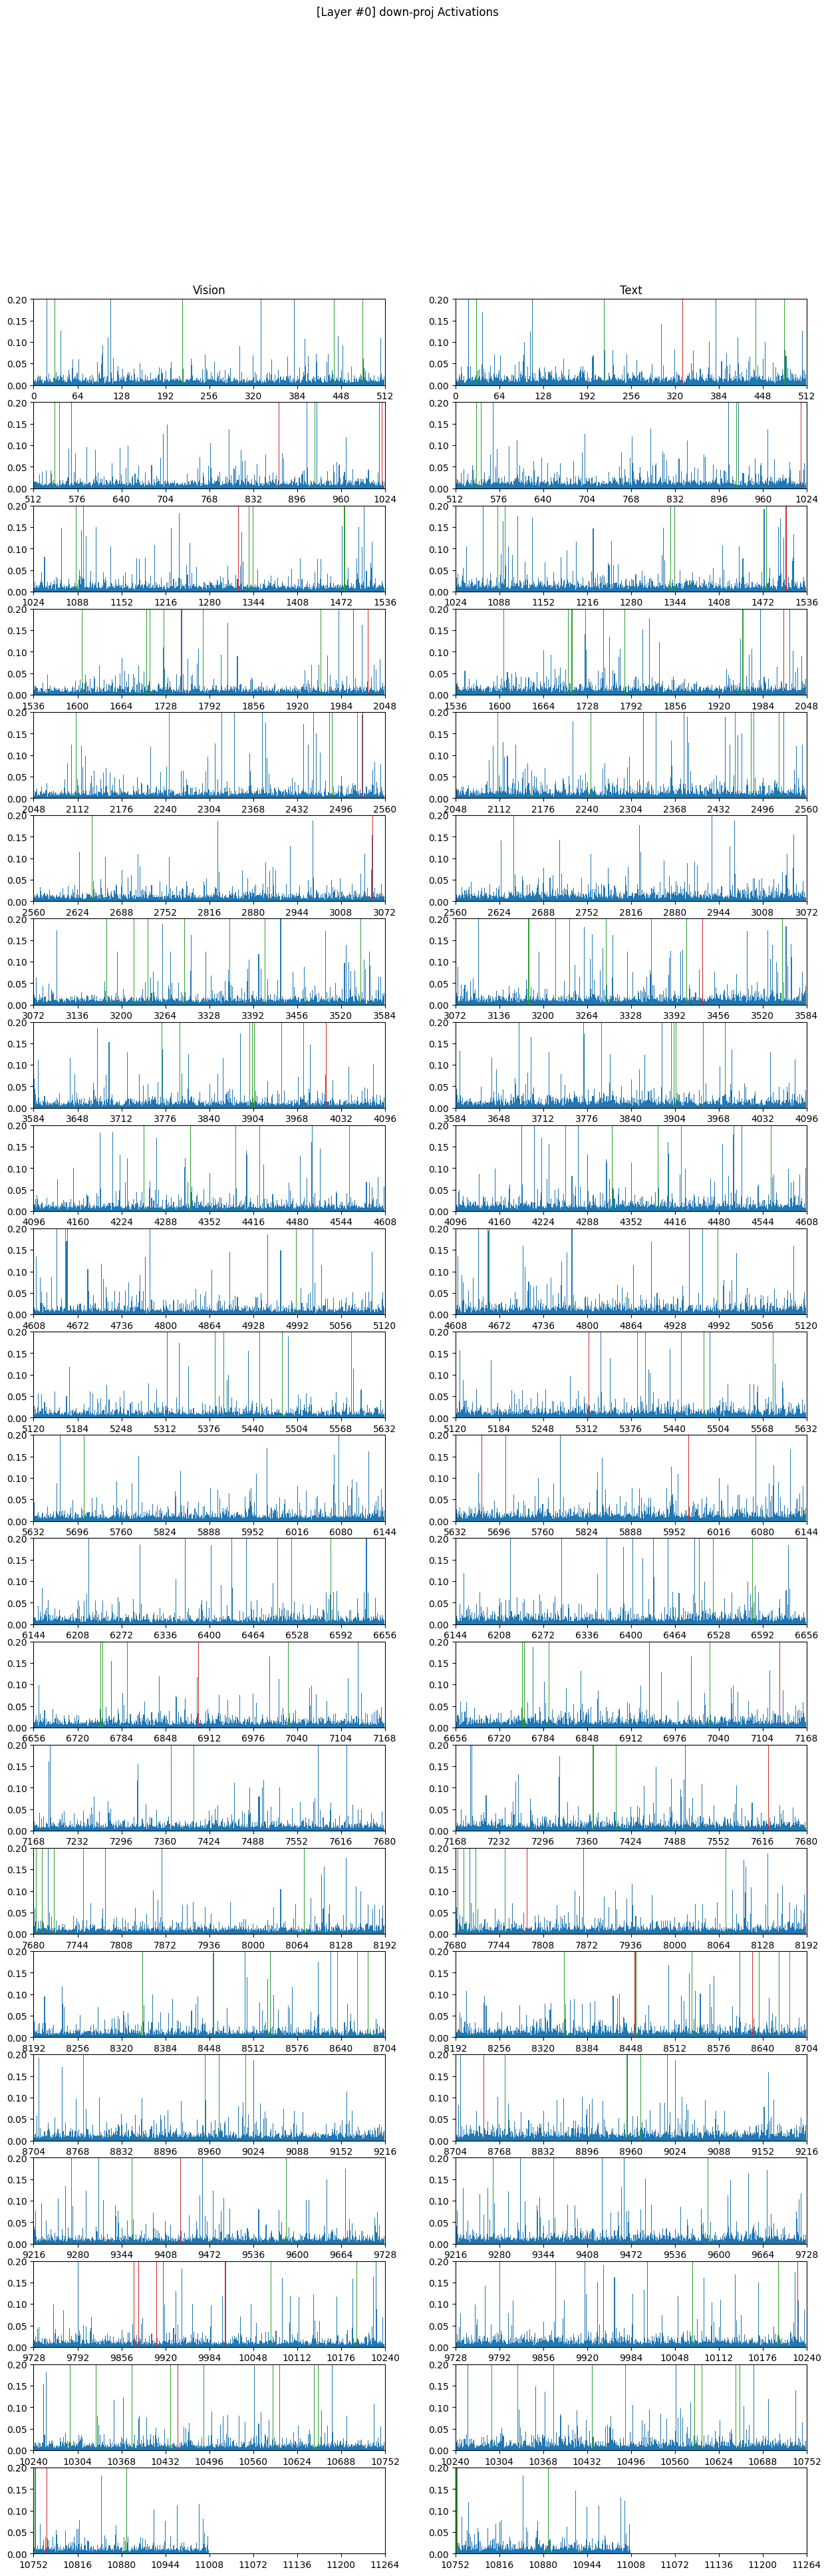

In [7]:
layer = 0
comp = 'down-proj'
vision_per_channel = load_act(f'{SNAPSHOT_PATH}/activations', f'{layer}-self-{comp}')
text_per_channel = load_act(f'{SNAPSHOT_PATH}/activations-text', f'{layer}-self-{comp}')
titles = [
    f'[Layer #{layer}] {comp} Activations',
    'Vision',
    'Text',
]
plot_layer_2(vision_per_channel, text_per_channel, titles)

In [15]:
def plot_all_comp_1(layer, channel, gen=False):
    plt.figure(figsize=(10, 16))

    for i, comp in enumerate(['self-q-proj', 'self-o-proj', 'self-up-proj', 'self-down-proj']):
        if gen:
            title_type = 'Gen'
            path_suffix = '-gen'
        else:
            title_type = 'Prompt'
            path_suffix = ''
        title = f'[L{layer}.{comp}] Text ({title_type})'
        ax = plt.subplot(4, 2, i * 2 + 1)
        x = load_channel(f'{SNAPSHOT_PATH}/activations', f'{layer}-{comp}', channel, seq_end=10).detach().cpu().numpy()
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)
        title = f'[L{layer}.{comp}] Multimodal ({title_type})'
        ax = plt.subplot(4, 2, i * 2 + 2)
        x = load_channel(f'{SNAPSHOT_PATH}/activations{path_suffix}', f'{layer}-{comp}', channel, seq_start=10).detach().cpu().numpy()
        plot_channel(ax, x)
        ax.set_title(title)
        print(title)

    # plt.savefig(f'./snapshot/img/activations-per-channel/{layer}.{channel}{path_suffix}.png')

[L31.self-q-proj] Text (Gen)
[L31.self-q-proj] Multimodal (Gen)
[L31.self-o-proj] Text (Gen)
[L31.self-o-proj] Multimodal (Gen)
[L31.self-up-proj] Text (Gen)
[L31.self-up-proj] Multimodal (Gen)
[L31.self-down-proj] Text (Gen)
[L31.self-down-proj] Multimodal (Gen)


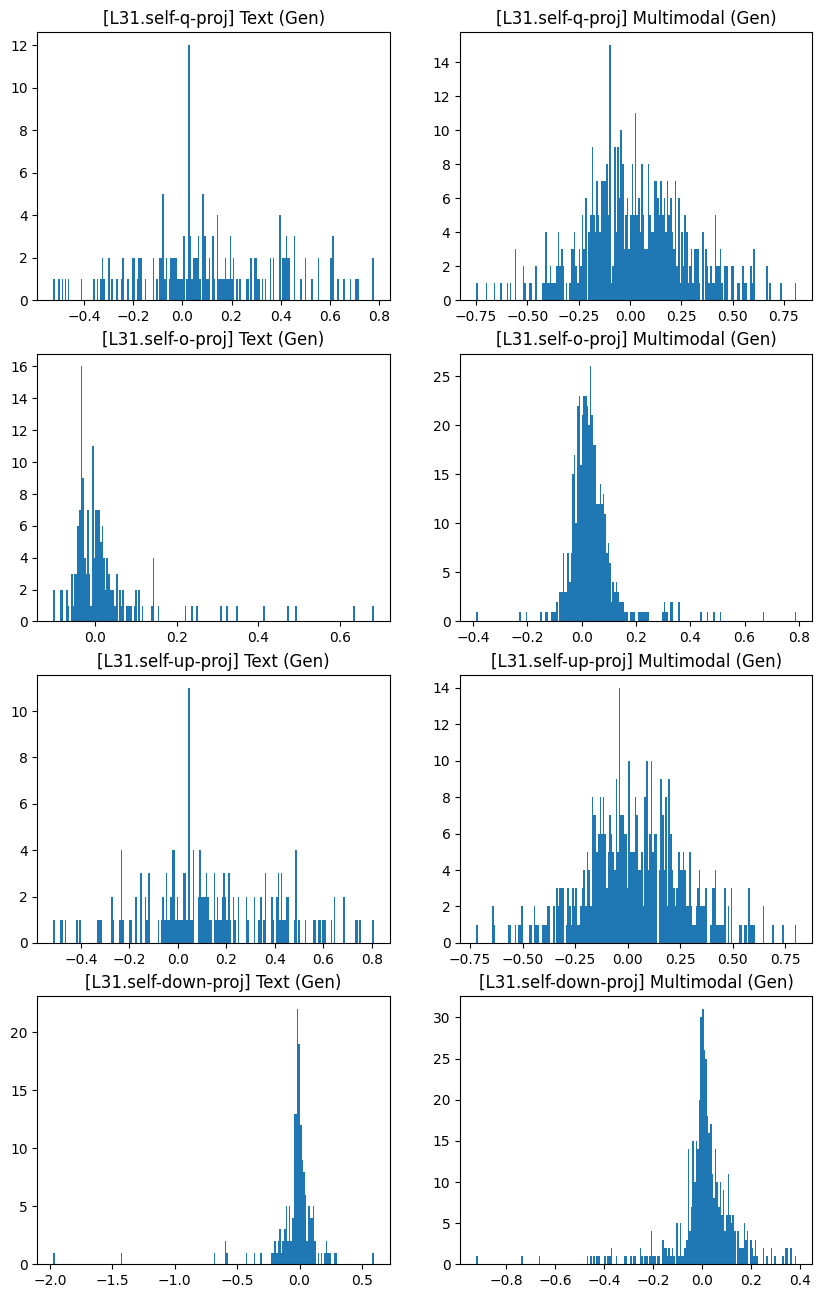

In [17]:
layer=31
plot_all_comp_1(layer, channel=31, gen=True)